# Natural Computing, Assignment 2
## Exercise 1
### (b)

In [ ]:
import numpy as np
from pso import PSO_1b

x1 = [-400, -400]
x2 = [-410, -410]
x3 = [-415, -415]
v = [-50, -50]
ws = [2, 0.5, 0.1]

# for w in ws:
#     particles = np.asarray([x1, x2, x3])
#     velocities = np.full_like(particles, v)
#     pso = PSO_1b(particles, velocities, w)
#     pso.run(1)
#     pso.show_stats()


## 3 - PSO for clustering

Shape of samples:  (400, 2)
Shape of labels: (400,)


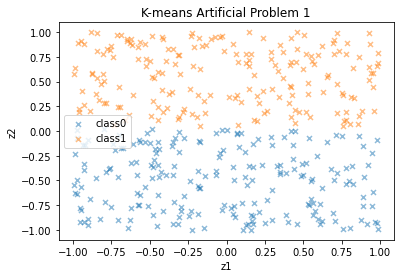

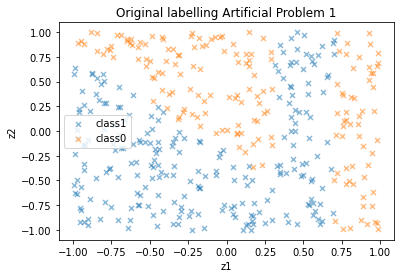

In [6]:
import numpy as np
from kmeans import KMeansClustering as KMeans
import matplotlib.pyplot as plt
from pso import PSO_1b
from datasets import artificial_problem_1

artOne = artificial_problem_1(400)
samples, l = artOne.get_samples()
my_k_means = KMeans(nr_input_dimensions = 2, nr_data_points =400 ,nr_clusters =2 , data=samples,labels = l)
a, centroids, fitness_k = my_k_means.k_means(100)

print("Shape of samples: ", samples.shape)
print("Shape of labels:", l.shape)

correct = 0
for i in range(len(a)):
    if(a[i]==l[i]):
        correct +=1

marker = "x"
alpha = 0.5
size = 25
plt.scatter(samples[a==0, 0], samples[a==0, 1], label="class0", marker=marker, alpha=alpha, s=size)
plt.scatter(samples[a==1, 0], samples[a==1, 1], label="class1", marker=marker, alpha=alpha, s=size)
plt.title("K-means Artificial Problem 1")
plt.xlabel("z1")
plt.ylabel("z2")
plt.legend()
plt.show()

plt.scatter(samples[l==0, 0], samples[l==0, 1], label="class1", marker=marker, alpha=alpha, s=size)
plt.scatter(samples[l==1, 0], samples[l==1, 1], label="class0", marker=marker, alpha=alpha, s=size)
plt.title("Original labelling Artificial Problem 1")
plt.xlabel("z1")
plt.ylabel("z2")
plt.legend()
plt.show()


In [7]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from datasets import artificial_problem_1
from pso import PSO_base
# from pso import PSO_gbest


class PSO_gbest(PSO_base):
    """Adaptation of the PSO_1b class for exercise 3

    Parameters
    ----------
    n_particles: int
        Number of particles used for clustering
    v_initial: float, tuple, NumpyArray
        Initial velocity of each particle. 
    n_clusters: int
        Number of clusters that shall be found
    w: float
        Inertia weight behavior
    r: tuple of float
        r[0] for r_individual and r[1] for r_social
        ...
    alpha: float
        ...
    clip_range: tuple
        Min and max values of particle values. Default: (-1, 1)
    """
    def __init__(self, data, labels, n_particles=10, v_initial=0.0, n_clusters=2, w=0.7298, r=None, alpha=1.4961,clip_range=(-1, 1), n_features = 2):
        self.data_vectors = data
        self.labels = labels
        self.n_clusters = n_clusters
        self.n_features = n_features
        clip_range = np.zeros((2, n_features))
        clip_range[0] = np.min(data, axis=0)
        clip_range[1] = np.max(data, axis=0)
        #particles = np.random.uniform(clip_range[0], clip_range[1], (n_particles, n_clusters, n_features))  
        mean = np.asarray([np.mean(data[..., i]) for i in range(data.shape[-1])])
        # print("mean.shape:", mean.shape)
        # print("mean:", mean)
        particles = np.random.normal(mean, 1.0, (n_particles, n_clusters, n_features))
        #par_ind = np.random.choice(data.shape[0], n_particles*n_clusters,  replace=False)
        #particles = np.reshape(data[par_ind,:], (n_particles,n_clusters,n_features))
        super().__init__(particles, v_initial, w, r, alpha, clip_range)

    def compute_fitness(self, particles):
        """
        for each data vector z_p
          (i)   find Euclidean distance d(z_p, m_ij) to all 
                cluster centroids C_ij
          (ii)  assign z_p to cluster C_ij such that 
                d(z_p, m_ij) is the minimum for C_ij
          (iii) calculate the fitness using eq.(8)
        """
        fitness = np.zeros(particles.shape[0])
        for i, particle in enumerate(particles):
            distances_particle = np.zeros((self.data_vectors.shape[0], self.n_clusters))
            for j, centroid in enumerate(particle):
                distances_particle[:,j] = np.linalg.norm(self.data_vectors - np.ones(self.data_vectors.shape)*centroid, axis = 1)
            min_distances = np.min(distances_particle, axis=1)
            assigned_clusters =np.argmin(distances_particle, axis=1)
            present_clusters, counts = np.unique(assigned_clusters, return_counts=True) 
            # calculate fitness of this particle
            J_e = 0
            n_clusters_found = 0
            for cluster_i in present_clusters:
                J_e += np.sum(min_distances[assigned_clusters==cluster_i]) / np.count_nonzero(assigned_clusters==cluster_i)
                n_clusters_found += 1
            fitness[i] = J_e / n_clusters_found
        return fitness
            
    def run(self, n_iter=1):
        """Runs the algorithm for n iterations.
        """
        # set starting best position and fitness
        self.update_bests(self.particles, self.fitness)
        
        # iterate
        fitness_series = np.zeros((n_iter, self.particles.shape[0]))
        for i in range(n_iter):
            self.particles = self.particles + self.velocities
            if not (self.clip_min is None and self.clip_max is None):
                self.particles = np.clip(self.particles, self.clip_min, self.clip_max)
            self.fitness = self.compute_fitness(self.particles)
            self.update_bests(self.particles, self.fitness)
            fitness_series[i] = self.fitness
            self.update_v(self.particles)
        return fitness_series
   
    def plot(self, title=None, figname=""):
        title = title if title is not None else "PSO-gbest: classes and centroids"
        if self.n_features == 2:
            for i in range(self.n_clusters):
                l = f"class {i}"
                plt.scatter(self.data_vectors[self.labels==i, 0], self.data_vectors[self.labels==i, 1], label=l, marker="x", alpha=0.5, s=25)
            plt.scatter(self.global_best[:, 0], self.global_best[:, 1], color="black", label="best centroids")
            plt.title(title)
            plt.xlabel("x")
            plt.ylabel("y")
            plt.legend()
            plt.show()
        elif self.n_features > 2:  # make scatter-subplots for higher-dimensional data
            labels = np.unique(self.labels)
            fig, axs = plt.subplots(self.n_features, self.n_features, sharex='col', sharey='row', figsize=(8,8), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
            for i in range(self.n_features):
                for j in range(self.n_features):
                    if i!=j:
                        for c in labels:
                            axs[j, i].scatter(self.data_vectors[self.labels==c, i], self.data_vectors[self.labels==c, j], label=c, marker="x", alpha=0.5, s=25)
                        axs[j, i].scatter(self.global_best[:, i], self.global_best[:, j], color="black", label="best centroids")
                        axs[-1, i].set_xlabel(i)
                        axs[j, 0].set_ylabel(j)
            print("global best.shape:", self.global_best.shape)
            print("global_best:", self.global_best)
            lines, labels = fig.axes[-2].get_legend_handles_labels()
            fig.legend(lines, labels, bbox_to_anchor=(0.315, 0.88))
            plt.suptitle(title)
            plt.savefig("results/PSO_"+figname)
            fig.show()
            

        

# # my_pso.show_stats()

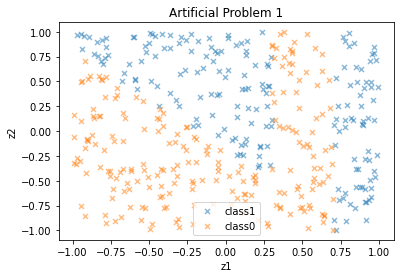

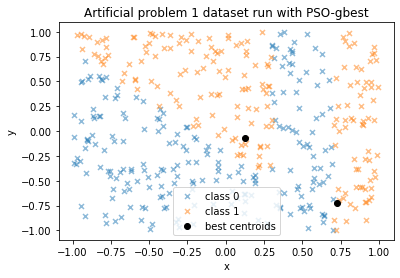

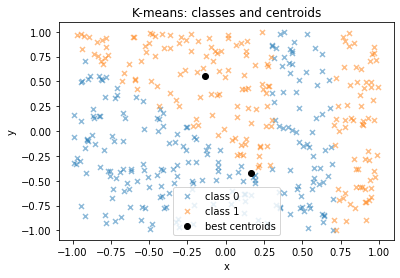

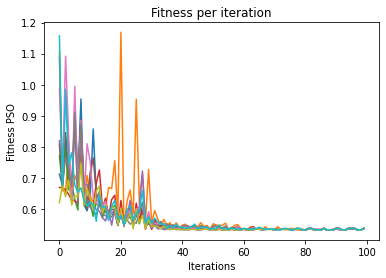

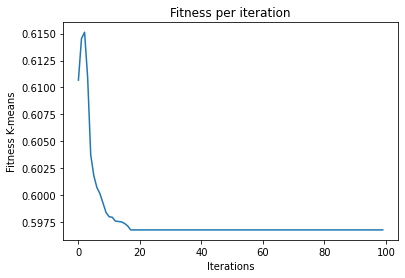

k_means 0.5967951003401927
PSO 0.5326703965141959


In [8]:

artOne = artificial_problem_1(400)
artOne.plot()
data, labels = artOne.get_samples()
my_pso = PSO_gbest(data = data, labels = labels, n_particles=20)
fitness_pso = my_pso.run(100)
my_pso.plot("Artificial problem 1 dataset run with PSO-gbest", figname="AP1_scatter")

my_k_means = KMeans(nr_input_dimensions = 2, nr_data_points =400 ,nr_clusters =2 , data=data, labels =labels)
a, centroids ,fitness_k = my_k_means.k_means(100)
my_k_means.plot(figname="AP1_scatter")

plt.figure()
for f in range(10):
    #print(fitness_pso[:, f])
    plt.plot(fitness_pso[:, f])
plt.title("Fitness per iteration")
plt.xlabel("Iterations")
plt.ylabel("Fitness PSO")
plt.savefig("results/PSO_AP1_fitness")
plt.show()

plt.figure()
plt.plot(fitness_k)
plt.title("Fitness per iteration")
plt.xlabel("Iterations")
plt.ylabel("Fitness K-means")
plt.savefig("results/Kmeans_AP1_fitness")
plt.show()

print("k_means",min(fitness_k))
print("PSO",np.min(fitness_pso))

In [4]:
#Load the iris data
import pandas as pd

data = pd.read_csv("/work/ru-course-natural-computing/assignment_2/data/iris.data", )
print(data.columns)
print(data.to_numpy().shape)
iris_labels = data["Iris-setosa"].to_numpy()
iris_data = data[['5.1', '3.5', '1.4', '0.2']].to_numpy()
print(type(iris_data))
print("iris_data.shape:", iris_data.shape)
print("iris_labels.shape:", iris_labels.shape)
print("unique labels: ", np.unique(iris_labels))

Index(['5.1', '3.5', '1.4', '0.2', 'Iris-setosa'], dtype='object')
(149, 5)
<class 'numpy.ndarray'>
iris_data.shape: (149, 4)
iris_labels.shape: (149,)
unique labels:  ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


global best.shape: (3, 4)
global_best: [[5.00217201 3.34847047 1.38178281 0.32772158]
 [6.33173007 2.84380054 4.8297593  1.6694489 ]
 [7.50934797 4.12412115 3.69864599 1.39581768]]
global best.shape: (3, 4)
global_best: [[5.00408163 3.41632653 1.46530612 0.24489796]
 [5.88360656 2.74098361 4.38852459 1.43442623]
 [6.85384615 3.07692308 5.71538462 2.05384615]]


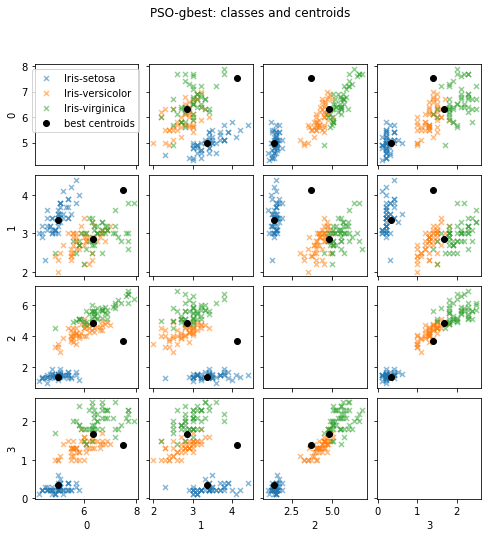

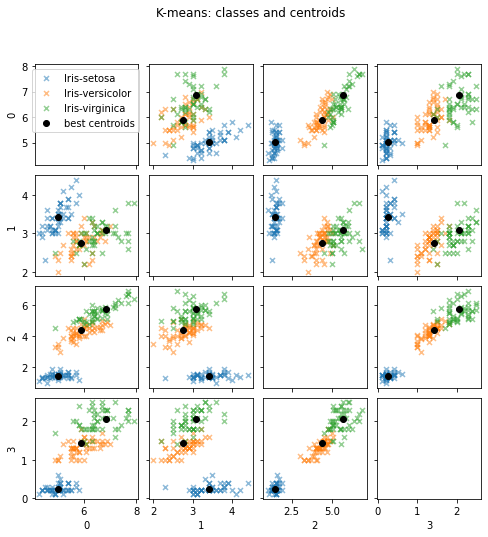

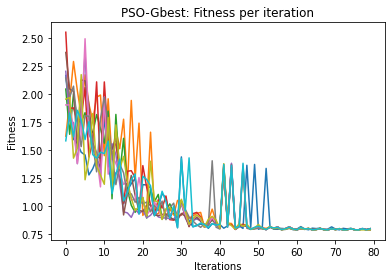

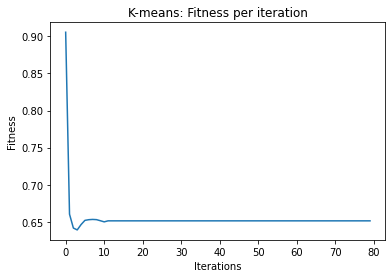

k_means 0.6390663113433254
PSO 0.7872320801079857


In [9]:
my_pso = PSO_gbest(data=iris_data, labels=iris_labels, n_particles = 10, n_clusters=3, w=0.7298, r=(1,1), n_features = 4)
# my_pso = PSO_gbest(data=iris_data, labels=iris_labels, n_particles = 10, n_clusters=3, w=0.70, n_features = 4)
# my_pso.plot("gbest_PSO on Iris data at initialization")
fitness = my_pso.run(80)
my_pso.plot(figname="Iris_scatter")

# green
my_k_means = KMeans(nr_input_dimensions = 4, nr_data_points =149 ,nr_clusters =3 , data=iris_data, labels =iris_labels)
a, centroids, k_fit = my_k_means.k_means(80)
my_k_means.plot(figname="Iris_scatter")
plt.figure()
for f in range(10):
    #print(fitness[:, f])
    plt.plot(fitness[:, f])
plt.title("PSO-Gbest: Fitness per iteration")
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.savefig("results/PSO_Iris_fitness")
plt.show()

plt.figure()
plt.plot(k_fit)
plt.title("K-means: Fitness per iteration")
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.savefig("results/Kmeans_Iris_fitness")
plt.show()


print("k_means",min(k_fit))
print("PSO",np.min(fitness))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=48486dc9-a1a6-4dac-ab77-4156e0b947fb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>